### Sending a request to the torchserve encoder service for the Segment Anything model (SAM)

When running services locally, make sure to select the correct port. 70* for the cpu service, 80* for the gpu service.

Note, the GPU service doesn't support the decoder model since this can be run on the CPU service!

The CPU service supports the encoder (slow) and the decoder (fast).

In [13]:
import httpx
import base64
from PIL import Image
from PIL.ImageOps import autocontrast
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import json

# default localhost endpoints after starting both containers, see README
# encode_url="http://127.0.0.1:7080/predictions/sam_vit_h_encode"
encode_url="http://127.0.0.1:8080/predictions/sam_vit_h_encode"

pth_slick = "../data/tile_with_slick_512_512.png"

We'll run SAM on a small subset of a Sentinel-1 image that captured an oil slick on the ocean from a shipping vessel.

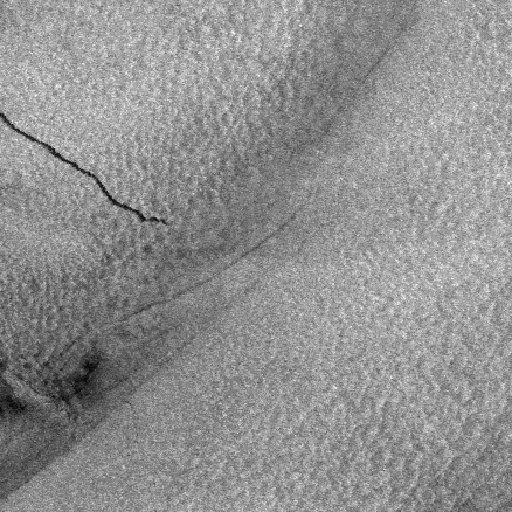

In [2]:
img_slick = Image.open(pth_slick)
autocontrast(img_slick, cutoff=0, ignore=None, mask=None, preserve_tone=False)

Reads image as bytes, converts bytes to string so it can be sent as a post request

In [3]:
with open(pth_slick, 'rb') as f:
    byte_string = f.read()
    base64_string = base64.b64encode(byte_string).decode('utf-8')

payload = {"encoded_image": base64_string}

Let's run the image encoder locally. Use the CPU endpoint if you don't have a GPU. Timings will differ based on the GPU type or if running on the CPU it will take over a minute for an unoptimized model. Time to encode image on 1080 Ti GPU is about 2 seconds.

In [4]:
%%time
try:
    response = httpx.post(encode_url, json=payload, timeout=None)
except (BrokenPipeError, httpx.RemoteProtocolError, ConnectionResetError) as e:
    print("wait and try again")

CPU times: user 14.5 ms, sys: 5.41 ms, total: 19.9 ms
Wall time: 1.27 s


In [5]:
response

<Response [200 ]>

Accessing the image embeddings for the oil slick scene and converting to a numpy array. The image embeddings represent the features of the image that we can produce mask predictions from.

In [6]:
encoded_embedding_string = response.json()['image_embedding']
base64_bytes = base64.b64decode(encoded_embedding_string)
image_embedding = np.frombuffer(base64_bytes, dtype=np.float32)
image_embedding

array([-0.13286641, -0.17649937, -0.17171675, ..., -0.1328539 ,
       -0.1372815 , -0.1409665 ], dtype=float32)

Next we send the image embeddings to the decoder service

In [28]:
img_shape = np.array(img_slick).shape
input_point_not_on_slick = (10, 120)
input_point_on_slick = (6, 120)
points = [input_point_on_slick , input_point_not_on_slick]
input_label = [1,0]
# TODO check this api. is this correct? should I use 
# an endpoint key isntead of validating multiple keys to switch how decode is applied?
decode_payload = {
    "image_embeddings": encoded_embedding_string,
    "image_shape": img_shape,
    "input_label": input_label,
    "input_prompt": points,
    "decode_type": "multi_point"
}

In [18]:
%%time
decode_url="http://127.0.0.1:7080/predictions/sam_vit_h_decode" # make sure to select correct port. 70* for cpu, 80* for gpu
response = httpx.post(decode_url, json=decode_payload, timeout=None)

CPU times: user 30.4 ms, sys: 3.31 ms, total: 33.7 ms
Wall time: 170 ms


In [19]:
response

<Response [200 ]>

In [20]:
encoded_masks_string = response.json()['masks']
base64_bytes_masks = base64.b64decode(encoded_masks_string)
masks = np.frombuffer(base64_bytes_masks, dtype=bool)

There are four masks, each with their own confidence score, predicted for the single point prompt. SAM makes an effort to predict valid masks in cases where there is ambiguity as to which object is desired and minimal prompting. See the SAM paper https://arxiv.org/pdf/2304.02643.pdf for details

In [23]:
masks = masks.reshape((1,4,512, 512))

Setting up plotting functions

In [26]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

With our encoder and decoder service, we get a solid mask prediction by just supplying a point on the object of interest!

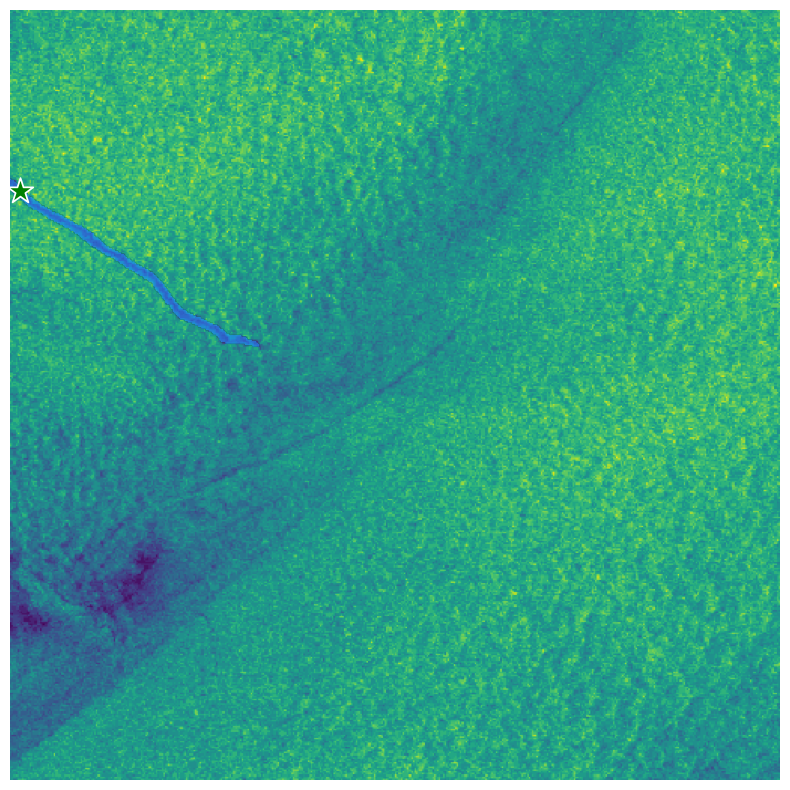

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(np.array(img_slick))
show_mask(masks[0,1,:,:], plt.gca())
input_point_arr = np.array(input_point_on_slick)[np.newaxis,:]
input_label_arr = np.array(input_label[0])[np.newaxis]
show_points(input_point_arr, input_label_arr, plt.gca())
plt.axis('off')
plt.show()

Next let's test the geospatial endpoint. For geospatial imagery it is more useful to return a georeferenced mask instead of an unreferenced numpy array so that we can plot these predictions on a map and associate them with other geospatial data.

In [30]:
import rasterio
import io
from skimage import img_as_ubyte
with rasterio.open("../data/sample-georeferenced_burn_scar.tif") as dataset:
    arr = dataset.read()
    bbox = dataset.bounds
    crs = "EPSG:32610"


arr = img_as_ubyte(arr).transpose((1,2,0))

img = Image.fromarray(arr)

# Create byte stream
buffered = io.BytesIO()
img.save(buffered, format="PNG")
img_str = base64.b64encode(buffered.getvalue())
base64_string = img_str.decode('utf-8')
payload = {"encoded_image": base64_string}

In [31]:
%%time
try:
    response = httpx.post(encode_url, json=payload, timeout=None)
except (BrokenPipeError, httpx.RemoteProtocolError) as e:
    print("wait and try again")

CPU times: user 22.6 ms, sys: 0 ns, total: 22.6 ms
Wall time: 1.33 s


In [32]:
encoded_embedding_string = response.json()['image_embedding']
base64_bytes = base64.b64decode(encoded_embedding_string)
image_embedding = np.frombuffer(base64_bytes, dtype=np.float32)
image_embedding

array([-0.0435573 , -0.03077952,  0.0131394 , ..., -0.02138667,
       -0.06629068, -0.06409254], dtype=float32)

### TODO no multi point example here yet

In [17]:
input_point_on_burn = (220,120)

We'll test SAM on a Sentinel-2 image of a burn scar in a USA agricultural region. SAM does a decent job with single point prompting of delineating the burn scar but adds in some incorrect pixels to the mask.

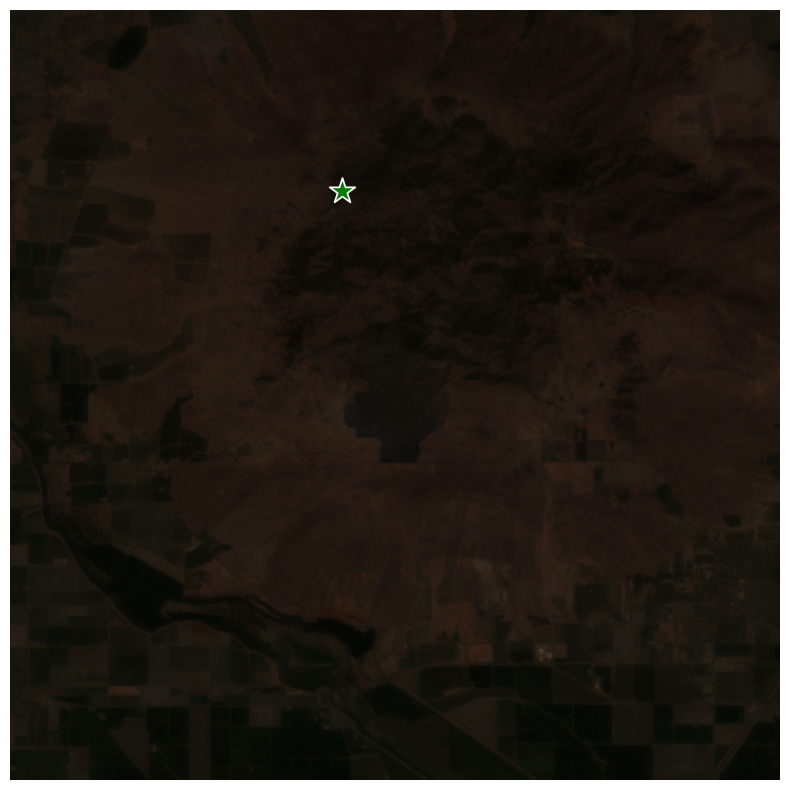

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(np.array(img))
input_point_arr = np.array(input_point_on_burn)[np.newaxis,:]
input_label_arr = np.array(input_label)[np.newaxis]
show_points(input_point_arr, input_label_arr, plt.gca())
plt.axis('off')
plt.show() 

Our source crs. The decoder service will reproject the outputs to WGS84 no matter the source CRS (the source CRS can only be supplied via epsg code).

In [19]:
crs

'EPSG:32610'

In [20]:
img_shape = img.size
foregrounds_on_burn = [(220,120)]
backgrounds_on_burn = [(510,510)]
decode_payload = {
    "image_embeddings": encoded_embedding_string,
    "image_shape": img_shape,
    "input_labels": input_labels,
    "foreground_points": foregrounds_on_burn,
    "background_points": backgrounds_on_burn,
    "crs":crs,
    "bbox": list(bbox),
}

In [21]:
%%time
decode_url="http://127.0.0.1:7080/predictions/sam_vit_h_decode" # make sure to select correct port. 70* for cpu, 80* for gpu
response = httpx.post(decode_url, json=decode_payload, timeout=None)

CPU times: user 33.7 ms, sys: 422 µs, total: 34.1 ms
Wall time: 480 ms


In [22]:
response

<Response [200 ]>

In [23]:
geojson_masks = response.json()['geojsons']

In [24]:
type(geojson_masks)

list

In [25]:
type(geojson_masks[0])

str

In [26]:
geojson_masks[0][0:1000]

'{"type": "MultiPolygon", "coordinates": [[[[-121.8651432983559, 39.267087860246136], [-121.86516073583847, 39.26600675957935], [-121.86481304504339, 39.26600337042328], [-121.86479560222116, 39.267084470960405], [-121.8651432983559, 39.267087860246136]]], [[[-121.86827691364945, 39.26684804167494], [-121.86828126103502, 39.26657776622344], [-121.86793356704302, 39.26657438634321], [-121.86792921832252, 39.266844661762384], [-121.86827691364945, 39.26684804167494]]], [[[-121.87700382625258, 39.264769991766855], [-121.8770081398002, 39.264499715406565], [-121.87631277031905, 39.26449300701456], [-121.87630845410179, 39.26476328331067], [-121.87700382625258, 39.264769991766855]]], [[[-121.873861676372, 39.26555059915932], [-121.87316629725841, 39.26554387182982], [-121.87317062566362, 39.26527359586188], [-121.872822937529, 39.26527023067258], [-121.87282726721082, 39.26499995472384], [-121.87317495401062, 39.265003319880954], [-121.87318793870224, 39.26419249186028], [-121.8738833044676

In [27]:
geojson_dict = json.loads(geojson_masks[0])

In [28]:
with open('multi_polygon.geojson', 'w') as f:
    f.write(geojson_masks[3])

In [29]:
len(geojson_masks)

4

Check out the geojson result in your favorite GIS! Like the slick image, we have 4 masks, represented by 4 MultiPolygon types.